# Installing modules and Importing Libraries



In [1]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 67.4 MB/s eta 0:00:00


In [2]:
import os
import torch
import random
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as tfms

#  Loading the models

In [3]:
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

# Setup device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

# Load necessary models
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(torch_device)
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

print("loaded all components")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

loaded all components


In [4]:
# del vae
# del unet
# del scheduler
# del tokenizer
# del text_encoder
# torch.cuda.empty_cache()

# Testing purposes

In [5]:
# input_image = Image.open('dog.jpg').resize((512, 512))
# encoded = pil_to_latent(input_image)
# decoded = latents_to_pil(encoded)[0]  #same as original image
# # show_images([encoded])

In [6]:
# # Let's visualize the four channels of this latent representation:
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for c in range(4):
#     axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')
#     axs[c].set_title(f'Channel {c+1}')

# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# sum_image = encoded[0].sum(dim=0).cpu()
# avg_image = encoded[0].mean(dim=0).cpu()
# axs[0].imshow(sum_image, cmap='Greys')
# axs[0].set_title(f'Sum of channels (Cmap=GREYs)')
# axs[1].imshow(avg_image, cmap='Greys')
# axs[1].set_title(f'Avg of Channels (Cmap=GREYs)')
# axs[2].imshow(sum_image)
# axs[2].set_title(f'SUM')
# axs[3].imshow(avg_image)
# axs[3].set_title(f'AVG')

# Util functions

In [7]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # batch of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

In [8]:
def viewimages(originalimg,denoisedlatents,category):
  #shows original image and conditionally denoised latents

  denoisedimg = latents_to_pil(denoisedlatents)[0]

  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  # Display the original image
  ax[0].imshow(originalimg)
  ax[0].axis('off')
  ax[0].set_title('Original')

  # Display the denoised image
  ax[1].imshow(denoisedimg)
  ax[1].axis('off')
  ax[1].set_title(f'Denoised @ {category}')

  # Adjust the layout and display the plot
  plt.tight_layout()
  plt.show()

def viewclassimages(originalimg,denoisedlatents,timesteps):
  #shows original image and all conditionally denoised latents

  fig, ax = plt.subplots(1, 1+len(timesteps), figsize=(14, 14))

  # Display the original image
  ax[0].imshow(originalimg)
  ax[0].axis('off')
  ax[0].set_title('Original')

  # Display the denoised image
  for i in range(len(timesteps)):
    denoisedimg = latents_to_pil(denoisedlatents[i])[0]
    ax[i+1].imshow(denoisedimg)  # Display the denoised image
    ax[i+1].axis('off')  # Turn off axis
    ax[i+1].set_title(f't={timesteps[i]}')

  plt.tight_layout()
  plt.show()

# Task 1 (Text-to-Image Diffusion Model as Zero Shot Classifier)

In [9]:
#----------------------------------------------CONFIG----------------------------------------------
height,width = 512,512              # default height,width of Stable Diffusion model
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1                      # ????

In [10]:
def get_embeddings(class_name):
  prompt = f"A photo of a {class_name}"
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

  with torch.no_grad():
      text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings


# Prep latents (noising appropriately for start_step)
def noise_latents(start_step,encoded):
  noise = torch.randn_like(encoded)
  latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
  latents = latents.to(torch_device).float()
  return latents

def conditional_denoisation(start_step, latents, text_embeddings):
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      if i >= start_step: # << This is the only modification to the loop we do
          # print(i)    #start_step----->num_inference_steps

          # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
          latent_model_input = torch.cat([latents] * 2)
          latent_model_input = scheduler.scale_model_input(latent_model_input, t)

          # predict the noise residual
          with torch.no_grad():
              noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

          # perform guidance
          noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
          noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

          # compute the previous noisy sample x_t -> x_t-1
          latents = scheduler.step(noise_pred, t, latents).prev_sample

  return latents

def compute_l2_norm(original_latent, denoised_latent):
    if isinstance(original_latent, Image.Image):  # convert pixel space to latent spAace
      original_latent = pil_to_latent(original_latent)
    if isinstance(denoised_latent, Image.Image):
      denoised_latent = pil_to_latent(denoised_latent)

    #latent space / tensors
    return torch.norm(original_latent - denoised_latent, p=2).item()


def get_timesteps(N,num_inference_steps):
  ts = []
  weights = []
  for i in range(N):
      # timestep = random.randint(0, num_inference_steps)
      t = torch.rand(1).item()  # Sample from [0, 1]
      timestep = int(t * num_inference_steps)
      while timestep in ts:
        #  timestep = random.randint(0, num_inference_steps)
        t = torch.rand(1).item()  # Sample from [0, 1]
        timestep = int(t * num_inference_steps)
      t = torch.tensor(timestep, dtype=torch.long).unsqueeze(0)
      wei = torch.exp(-7 * (t/num_inference_steps))
      ts.append(timestep)
      weights.append(wei)

  print("timesteps",ts)
  return ts,weights

timesteps [1, 46, 4]
class airplane iter 0 timestep 2


  0%|          | 0/50 [00:00<?, ?it/s]

class airplane iter 1 timestep 19


  0%|          | 0/50 [00:00<?, ?it/s]

class airplane iter 2 timestep 32


  0%|          | 0/50 [00:00<?, ?it/s]

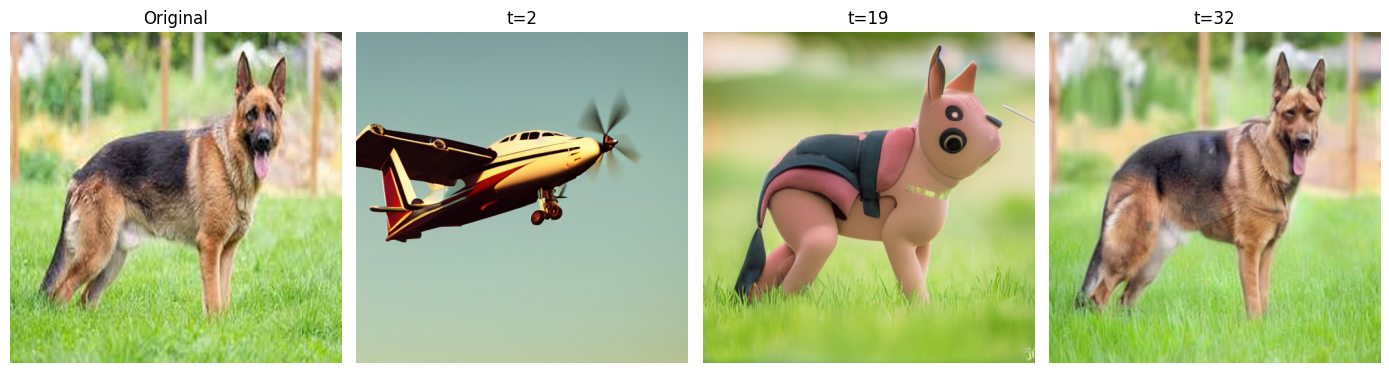

class horse iter 0 timestep 2


  0%|          | 0/50 [00:00<?, ?it/s]

class horse iter 1 timestep 19


  0%|          | 0/50 [00:00<?, ?it/s]

class horse iter 2 timestep 32


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:

def zeroshotclassifier(categories,image_path):
  #Encoding the image
  input_image = Image.open(image_path).resize((512, 512))
  encoded = pil_to_latent(input_image)

  # Prepping the Scheduler based on randomly sampled timestep
  num_inference_steps = 50            # Number of denoising steps

  #get randomly sampled timesteps for N iterations and their corresponding weights
  N = 3      #number of iterations
  ts,weights = get_timesteps(N,num_inference_steps)
  ts = [2,19,32]

  scores_matrix = []

  for cat in categories:
    class_scores = []
    class_denoised_latents = []
    for i,timestep in enumerate(ts):
      print("class",cat,"iter",i,"timestep",timestep)

      set_timesteps(scheduler, num_inference_steps)
      start_step = timestep

      text_embeddings = get_embeddings(cat)
      latents = noise_latents(start_step,encoded)
      denoised_latents = conditional_denoisation(start_step, latents, text_embeddings)
      score = compute_l2_norm(encoded, denoised_latents) ** 2
      class_scores.append(score*weights[i])
      class_denoised_latents.append(denoised_latents)

    viewclassimages(input_image,class_denoised_latents,ts)
    # scores_matrix.append(torch.tensor(class_scores).unsqueeze(0))
    scores_matrix.append(sum(class_scores)/len(class_scores))

  # scores_matrix = torch.cat(scores_matrix, dim=0)
  print("scores",scores_matrix)
  weight_vector = torch.tensor(weights).unsqueeze(1)
  print("weights",weight_vector)
  # result = torch.matmul(scores_matrix, weight_vector)
  result = torch.tensor(scores_matrix)
  print("final-vec",result)
  # print(scores_matrix.shape,weight_vector.shape,result.shape)
  index = torch.argmin(result)
  pred_class = categories[index]
  print(f"Predicted class: {pred_class}")


categories = ["airplane", "horse", "dog","tree"]
imgpath = 'dog.jpg'
zeroshotclassifier(categories,imgpath)